In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from DenseLayer import DenseLayer
from ActivationFunc import ReLU, SoftmaxCategoricalCrossEntropy
from Optimizers import StochasticGradientDescent
from Accuracy import Accuracy

%matplotlib inline

In [10]:
mnist = fetch_openml('mnist_784', version=1, cache=True, parser='auto')

X = mnist.data.to_numpy().astype('float32')
y = mnist.target.to_numpy().astype('uint8')

X /= 255.0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(f"Training shape: {X_train.shape}")
print(f"Testing shape: {X_test.shape}")

Training shape: (63000, 784)
Testing shape: (7000, 784)


In [11]:
dense1 = DenseLayer(784, 64)
activation1 = ReLU()
dense2 = DenseLayer(64, 10)
loss_activation = SoftmaxCategoricalCrossEntropy()
optimizer = StochasticGradientDescent(learning_rate=0.1, decay=1e-3, momentum=0.9)
accuracy = Accuracy()

In [12]:
EPOCHS = 10
BATCH_SIZE = 128 

num_samples = X_train.shape[0]
num_batches = num_samples // BATCH_SIZE

loss_history = []
acc_history = []

print(f"Starting training for {EPOCHS} epochs with batch size {BATCH_SIZE}")

for epoch in range(EPOCHS):
    # Shuffle
    indices = np.random.permutation(num_samples)
    X_train_shuffled = X_train[indices]
    y_train_shuffled = y_train[indices]
    
    epoch_loss = 0
    epoch_acc = 0
    
    for i in range(num_batches):
        start = i * BATCH_SIZE
        end = start + BATCH_SIZE
        batch_X = X_train_shuffled[start:end]
        batch_y = y_train_shuffled[start:end]
        
        # Forward
        dense1.forward(batch_X)
        activation1.forward(dense1.output)
        dense2.forward(activation1.output)
        
        loss = loss_activation.forward(dense2.output, batch_y)
        acc = accuracy.calculate(batch_y, loss_activation.output)
        
        epoch_loss += loss
        epoch_acc += acc
        
        # Backward
        loss_activation.backward(loss_activation.output, batch_y)
        dense2.backward(loss_activation.derivative_inputs)
        activation1.backward(dense2.derivative_inputs)
        dense1.backward(activation1.derivative_inputs)
        
        # Update
        optimizer.before_updating_params()
        optimizer.update_params(dense1)
        optimizer.update_params(dense2)
        optimizer.after_updating_params()
    
    avg_loss = epoch_loss/num_batches
    avg_acc = epoch_acc/num_batches
    loss_history.append(avg_loss)
    acc_history.append(avg_acc)
        
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f} - Acc: {avg_acc:.4f}")

Starting training for 10 epochs with batch size 128
Epoch 1/10 - Loss: 0.3541 - Acc: 0.8930
Epoch 2/10 - Loss: 0.1239 - Acc: 0.9629
Epoch 3/10 - Loss: 0.0919 - Acc: 0.9728
Epoch 4/10 - Loss: 0.0747 - Acc: 0.9779
Epoch 5/10 - Loss: 0.0643 - Acc: 0.9814
Epoch 6/10 - Loss: 0.0565 - Acc: 0.9833
Epoch 7/10 - Loss: 0.0507 - Acc: 0.9854
Epoch 8/10 - Loss: 0.0465 - Acc: 0.9871
Epoch 9/10 - Loss: 0.0430 - Acc: 0.9879
Epoch 10/10 - Loss: 0.0400 - Acc: 0.9895


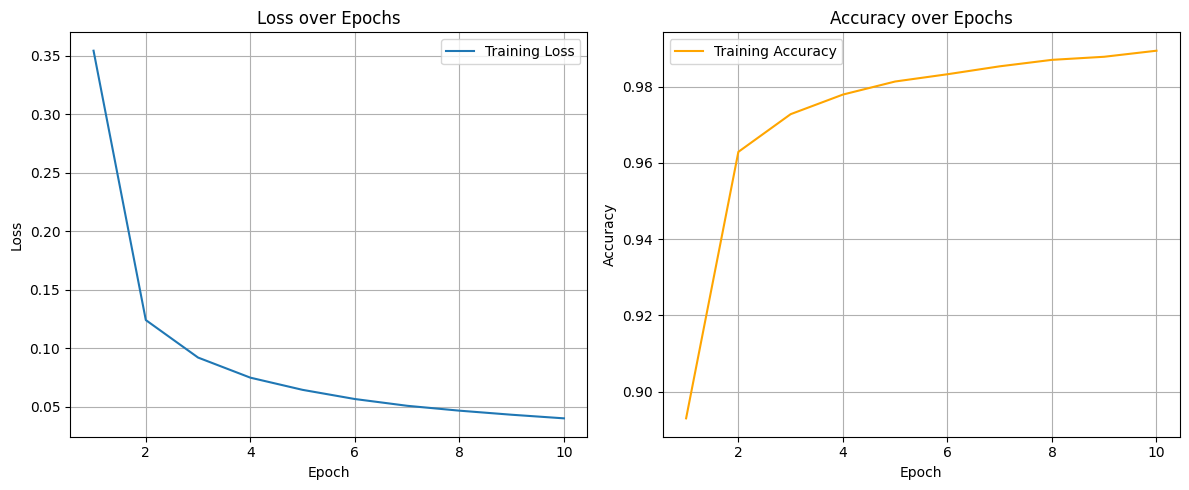

In [13]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS+1), loss_history, label='Training Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS+1), acc_history, label='Training Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [14]:
dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)

loss = loss_activation.forward(dense2.output, y_test)
acc = accuracy.calculate(y_test, loss_activation.output)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")

Test Loss: 0.0927
Test Accuracy: 0.9717


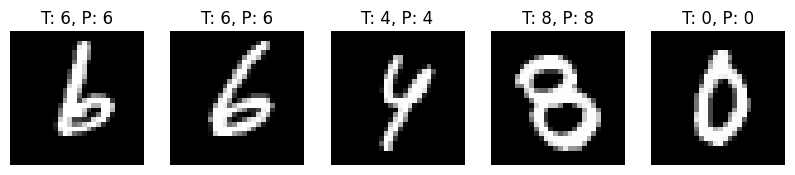

In [15]:
indices = np.random.choice(len(X_test), 5, replace=False)
predictions = np.argmax(loss_activation.output, axis=1)

plt.figure(figsize=(10, 5))
for i, idx in enumerate(indices):
    image = X_test[idx].reshape(28, 28)
    pred_label = predictions[idx]
    true_label = y_test[idx]
    
    plt.subplot(1, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(f"T: {true_label}, P: {pred_label}")
    plt.axis('off')
plt.show()